#  Image synthesis from attention model (Lee et al., 2017)
This notebook is intended to synthesize psedo binocular raivalry

Program Procedure
* 1 upload peudo binocular rivalry
* 2 load raw activity of summation neurons
* 3 downsample loaded activities
* 4 detect peack from downsampled time course
* 5 shuffle order of images
* 6 assign pseudo images to downsampled images
* 7 make parallel images
* 8 make noisy images

### After making images
* After concatenating images, 
* Under terminal,
* ffmpeg -r 20 -i %04d.jpg grating_random_transition.mp4


##### by Dr. Nishida, 2017
##### revised by Hamada Hiroaki, 2018

# 1.1 import modules

In [1]:
import cv2
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Basic setup for the synthesis

# 1.2 upload images

In [2]:
# upload images
InputDir = ''
n_ref_images = 8
img_list = list()
img_list.append(cv2.imread(InputDir + '_images/Gabor_Left.png'))
img_list.append(cv2.imread(InputDir + '_images/Gabor_Right.png'))
img_list.append(cv2.imread(InputDir + '_images/Gabor_Blended_1to4.png'))
img_list.append(cv2.imread(InputDir + '_images/Gabor_Blended_4to1.png'))
img_list.append(cv2.imread(InputDir + '_images/Gabor_V.png'))
img_list.append(cv2.imread(InputDir + '_images/Gabor_Inverse_V.png'))
img_list.append(cv2.imread(InputDir + '_images/Gabor_Mounted_Left.png'))
img_list.append(cv2.imread(InputDir + '_images/Gabor_Mounted_Right.png'))

In [3]:
print img_list[0].shape

(600, 600, 3)


In [4]:
img_h, img_w = img_list[0].shape[:2]
base_h = 854
base_w = 1520

img_ext = '.jpg'

# decide the location of output
outdir = '_out'
#os.mkdir(InputDir + outdir)

x1 = (base_w / 2 - img_w) / 2
y1 = (base_h - img_h) / 2
x2 = x1 + base_w / 2
y2 = y1

# 1.3 upload summation neurons' activity

In [5]:
# load the summation neurons
file = np.loadtxt('summation_120sec.txt', unpack=True)

In [6]:
resp = file[:, 1:]
print resp.shape
n_raw_samps = resp.shape[1]

(2, 240000)


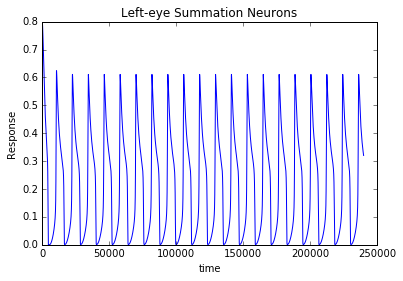

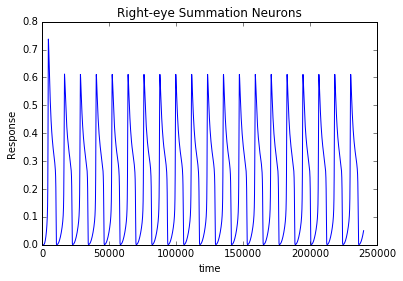

In [7]:
plt.figure(1)
plt.plot(resp[0, :])
plt.xlabel('time'); plt.ylabel('Response');
plt.title('Left-eye Summation Neurons')
plt.figure(2)
plt.plot(resp[1, :])
plt.xlabel('time'); plt.ylabel('Response');
plt.title('Right-eye Summation Neurons')
plt.show()

# 1.4 Down-sample time-course

2400


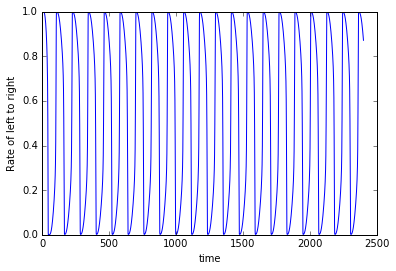

In [8]:
# Get the downsampled timecourse of mixing rate
samp_interval = 100
n_samps = n_raw_samps/samp_interval
tline = np.linspace(0, n_raw_samps-samp_interval, n_samps);
tline = [int(x) for x in tline]
ratio = resp[0, tline] / (resp[0, tline] + resp[1, tline])
print n_samps
plt.figure(1)
plt.plot(ratio)
plt.xlabel('time')
plt.ylabel('Rate of left to right')
plt.show()

# 1.5 Detect peak points from time courses

In [9]:
# Detect the peak points
def detect_PeakPoints(n_samps, ratio):
    peak_points = np.zeros(n_samps)
    for ii in range(1, n_samps-1):
        s1 = ratio[ii] - ratio[ii-1]
        s2 = ratio[ii+1] - ratio[ii]
        
        if s1 > 0 and s2 <= 0:
            peak_points[ii] = 1 # upward peak
        elif s1 < 0 and s2 >= 0:
            peak_points[ii] = -1 # downward peak
            
    # The number of peaks
    n_peak_points = len(np.where(peak_points != 0)[0])
    plt.figure(1)
    plt.plot(peak_points)
    plt.xlabel('time')
    
    return peak_points, n_peak_points    

# 1.5' Add some random num for transitions to the time series

In [10]:
# this function is intended to add random transition time
def add_random_transition(peak_points, ratio):
    # add random length for the transitions
    # search 
    peaks_where = np.where(abs(peak_points)==1);
    tmp_peak = 0;
    new_ratio = np.zeros(1);
    _, length = np.shape(peaks_where)

    for next_peak in peaks_where[0]:
        # random duration for transition
        random_transition = np.random.randint(0,100);
        a = ratio[next_peak]*np.ones(random_transition)
        b =  np.array(ratio[tmp_peak:next_peak])
        # concatenate original signal and extended peak
        new_concatenate = np.concatenate((b, a))
        new_ratio = np.concatenate((new_ratio, new_concatenate))
        # re-new tmp_peak
        tmp_peak = next_peak
    return new_ratio

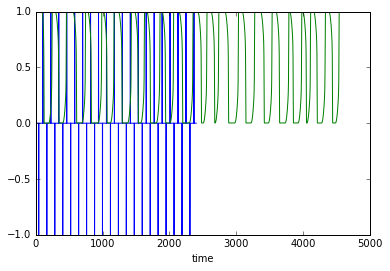

In [11]:
peak_points, n_peak_points = detect_PeakPoints(n_samps, ratio);
new_ratio = add_random_transition(peak_points, ratio)
plt.plot(new_ratio)

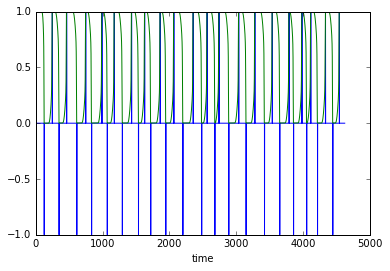

In [12]:
peak_points, n_peak_points = detect_PeakPoints(len(new_ratio), new_ratio);
plt.plot(new_ratio)

# 1.6 Get the order in which the reference images appear

In [13]:
def get_order(n_elements, n_classes):
    order_list = []

    for ii in range(n_elements):
        while 1:
            rnd = np.floor(np.random.rand(1) * n_classes)
            rnd = int(rnd)

            # Don't permit the same index in successive elements
            if len(order_list) <= 1 or rnd != order_list[ii - 1]:
                order_list.append(rnd)
                break

    # Match the last element to the first element
    order_list.append(order_list[0])
    
    return order_list

# 1.7 make a movie with single images

In [14]:
def single_images(img_list, img_order, n_samps, InputDir, outdir, ratio):
    pair_i = 1

    img1 = img_list[img_order[0]]
    img2 = img_list[img_order[1]]

    for ii in range(n_samps):
        img1_rate = ratio[ii];
        img2_rate = 1 - ratio[ii];

        if peak_points[ii] != 0:
            pair_i += 1
            if peak_points[ii] == 1:
                img2 = img_list[img_order[pair_i]]
            elif peak_points[ii] == -1:
                img1 = img_list[img_order[pair_i]]
    
        if np.shape(img1) == np.shape(img2):
            dst = cv2.addWeighted(img1, img1_rate, img2, img2_rate, 0)
        else:
            break
        
        merged_img = dst
        cv2.imwrite(InputDir + outdir + ('/%04d' % ii) + img_ext, merged_img)

# 1.8 make a movie with parallel images

In [15]:
# make a moview with parallel images
def parallel_images(img_list, img_order, n_samps, InputDir, outdir, ratio):
    pair_i = 1

    img1 = img_list[img_order[0]]
    img2 = img_list[img_order[1]]

    for ii in range(n_samps):
        img1_rate = ratio[ii];
        img2_rate = 1 - ratio[ii];

        if peak_points[ii] != 0:
            pair_i += 1
            if peak_points[ii] == 1:
                img2 = img_list[img_order[pair_i]]
            elif peak_points[ii] == -1:
                img1 = img_list[img_order[pair_i]]
    
        if np.shape(img1) == np.shape(img2):
            # merge images
            dst = cv2.addWeighted(img1, img1_rate, img2, img2_rate, 0)
        else:
            break
    
        # overlay the merged images on the background image
        merged_img = np.zeros((base_h, base_w, 3)) + 128
        merged_img[y1:y1+img_h, x1:x1+img_w] = dst
        merged_img[y2:y2+img_h, x2:x2+img_w] = dst
    
        cv2.imwrite(InputDir + outdir + ('/%04d' % ii) + img_ext, merged_img)

# 1.9 generate multiple parallel images for the without-noise condition

In [44]:
#  get first random images
img_order1 = get_order(n_peak_points + 1, n_ref_images)
# 
InputDir = '';
outdir = '_out1'
#os.mkdir(InputDir + outdir)
single_images(img_list, img_order1, len(new_ratio), InputDir, outdir, new_ratio)
parallel_images(img_list, img_order1, len(new_ratio), InputDir, outdir, new_ratio)

In [46]:
#  get second random images
img_order2 = get_order(n_peak_points + 1, n_ref_images)
# 
InputDir = '';
outdir = '_out2'
#os.mkdir(InputDir + outdir)
single_images(img_list, img_order2, len(new_ratio), InputDir, outdir, new_ratio)
parallel_images(img_list, img_order2, len(new_ratio), InputDir, outdir, new_ratio)

In [23]:
#  get third random images
img_order3 = get_order(n_peak_points + 1, n_ref_images)
# 
InputDir = '';
outdir = '_out3'
#os.mkdir(InputDir + outdir)
single_images(img_list, img_order3, len(new_ratio), InputDir, outdir, new_ratio)
parallel_images(img_list, img_order3, len(new_ratio), InputDir, outdir, new_ratio)

# 1.10 generate multiple parallel images for the with-noise condition

[-0.00636785 -0.00944181 -0.00700817 ...,  0.01195701  0.00410038
  0.00935143]


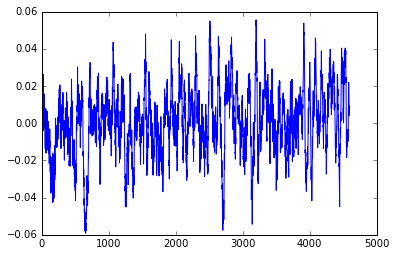

In [16]:
# generate random noise with gaussian
noise = np.random.randn(len(new_ratio))* 0.1
b = np.ones(30)/30
noise_ave = np.convolve(noise ,b,'valid')
print noise_ave
plt.plot(noise_ave)

In [17]:
def single_images_noise(img_list, img_order, n_samps, InputDir, outdir, noise, ratio):
    pair_i = 1

    img1 = img_list[img_order[0]]
    img2 = img_list[img_order[1]]

    for ii in range(n_samps):
        img1_rate = ratio[ii] + noise[ii];
        img2_rate = 1 - ratio[ii];

        if peak_points[ii] != 0:
            pair_i += 1
            if peak_points[ii] == 1:
                img2 = img_list[img_order[pair_i]]
            elif peak_points[ii] == -1:
                img1 = img_list[img_order[pair_i]]
    
        if np.shape(img1) == np.shape(img2):
            dst = cv2.addWeighted(img1, img1_rate, img2, img2_rate, 0)
        else:
            break
        
        merged_img = dst
        cv2.imwrite(InputDir + outdir + ('/%04d' % ii) + img_ext, merged_img)

In [18]:
# make a moview with parallel images
# input:
#         img_list:
#         img_order:
#         n_samps:
#         InputDir:
#         outdir:
#         noise:
#         ratio:
#         peak_points
def parallel_images_noise(img_list, img_order, n_samps, InputDir, outdir, noise, ratio, peak_points):
    pair_i = 1

    img1 = img_list[img_order[0]]
    img2 = img_list[img_order[1]]
    
    ratio_noise = np.zeros((len(ratio), 1))
    
    for ii in range(len(noise)):
       ratio_noise[ii] =  ratio[ii] + noise[ii];
    
    ratio_noise = ratio_noise/np.max(ratio_noise);

    for ii in range(n_samps):
        img1_rate = ratio_noise[ii]
        img2_rate = 1 - ratio_noise[ii];

        if peak_points[ii] != 0:
            pair_i += 1
            if peak_points[ii] == 1:
                img2 = img_list[img_order[pair_i]]
            elif peak_points[ii] == -1:
                img1 = img_list[img_order[pair_i]]
    
        #if np.shape(img1) == np.shape(img2):
            # merge images
        dst = cv2.addWeighted(img1, img1_rate, img2, img2_rate, 0)
        print dst
        #else:
        #    break
    
        # overlay the merged images on the background image
        merged_img = np.zeros((base_h, base_w, 3)) + 128
        merged_img[y1:y1+img_h, x1:x1+img_w] = dst
        merged_img[y2:y2+img_h, x2:x2+img_w] = dst
    
        cv2.imwrite(InputDir + outdir + ('/%04d' % ii) + img_ext, merged_img)

[-0.06929788 -0.08125329 -0.05804419 ..., -0.08370125 -0.06724604
 -0.07232589]


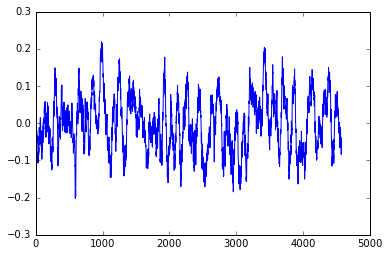

In [29]:
# generate random noise with gaussian
noise = np.random.randn(len(new_ratio))*0.5
b = np.ones(50)/50
noise_ave = np.convolve(noise ,b,'valid')
print noise_ave
plt.plot(noise_ave)

In [30]:
#  get first random images with noise
img_order3 = get_order(n_peak_points + 1, n_ref_images)
print img_order3

# 
InputDir = '';
#outdir = '_out_noise2'
outdir = '_out5'
#os.mkdir(InputDir + outdir)
parallel_images_noise(img_list, img_order3, len(new_ratio), InputDir, outdir, noise_ave, new_ratio, peak_points)

[5, 2, 7, 5, 0, 5, 2, 5, 0, 3, 5, 4, 5, 3, 0, 6, 5, 1, 7, 4, 6, 3, 5, 2, 3, 1, 2, 5, 4, 1, 6, 3, 0, 6, 0, 5, 4, 0, 6, 3, 5, 4, 5]
[[[128 128 128]
  [128 128 128]
  [128 128 128]
  ..., 
  [128 128 128]
  [128 128 128]
  [128 128 128]]

 [[128 128 128]
  [128 128 128]
  [128 128 128]
  ..., 
  [128 128 128]
  [128 128 128]
  [128 128 128]]

 [[128 128 128]
  [128 128 128]
  [128 128 128]
  ..., 
  [128 128 128]
  [128 128 128]
  [128 128 128]]

 ..., 
 [[128 128 128]
  [128 128 128]
  [128 128 128]
  ..., 
  [128 128 128]
  [128 128 128]
  [128 128 128]]

 [[128 128 128]
  [128 128 128]
  [128 128 128]
  ..., 
  [128 128 128]
  [128 128 128]
  [128 128 128]]

 [[128 128 128]
  [128 128 128]
  [128 128 128]
  ..., 
  [128 128 128]
  [128 128 128]
  [128 128 128]]]
[[[128 128 128]
  [128 128 128]
  [128 128 128]
  ..., 
  [128 128 128]
  [128 128 128]
  [128 128 128]]

 [[128 128 128]
  [128 128 128]
  [128 128 128]
  ..., 
  [128 128 128]
  [128 128 128]
  [128 128 128]]

 [[128 128 128]